# ShearLineCNN
> Shear Line Classification using CNN.

## Revision History

| #   | Date       | Action                                           | Modified by        |
|-----|------------|--------------------------------------------------|--------------------|
|     |            |                                                  |                    |
| 010 | 2025-05-16 | Optimize architecture                            | rmaniego           |
| 009 | 2025-05-16 | Improve architecture                             | rmaniego           |
| 008 | 2025-05-15 | Fix model metrics                                | rmaniego           |
| 007 | 2025-05-03 | Fix testing evaluation                           | rmaniego           |
| 006 | 2025-05-03 | Fix dataset loader                               | rmaniego           |
| 005 | 2025-05-03 | Fix segmentation dataset                         | rmaniego           |
| 004 | 2025-04-10 | Fix architecture to match dataset                | rmaniego           |
| 003 | 2025-04-10 | Update architecture base codes                   | rmaniego           |
| 002 | 2025-04-09 | Prepare dataset                                  | rmaniego           |
| 001 | 2025-03-29 | Create GitHub repository                         | rmaniego           |

## Step 1. Mount Google Drive

**Notes:**.
 - This requires GDrive permissions.
 - Update changes in local repository.
 - Re-run cell for every commit changes in the repository.
 - Colab is read only, unless set in GitHub FGPATs

```python
pip install jupyterlab
pip install notebook
jupyter notebook
```

**GitHub Personal Access Tokens (PAT)**
1. Go to `https://github.com/settings/tokens`.
2. On the sidebar, select `Fine-grained tokens`.
3. Fill-up appropriate details, limit read/write access.
4. Copy generated `PAT` to local environment variables.
5. Do the same to Google Colab secrets.
6. Once expired, move the old repo in GDrive to trash.

In [2]:
import os

github_fgpat = None
live_on_colab = False
environment_ready = False

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

try:
    from google.colab import drive, userdata

    drive.mount("/content/drive")

    live_on_colab = True
    github_fgpat = userdata.get("ShearLineCNN")
    print("Running on Google Colaboratory...")
except ImportError:
    print("Running locally...")

## Step 2. Check Colab Compute Engine Backend
**Note:** Execute to verify HW accelerator allocation, use information on manuscript.

HW accelerator availability may vary, so ensure that the session is timed and is connected to expected runtime environment in all iterations. Options include:
1. NVIDIA A100 Tensor Core GPU - high-performance deep learning training (recommended).
2. NVIDIA L4 Tensor Core GPU - optimized for AI inference tasks with high performance and efficiency (preferred during HP fine-tuning).
3. NVIDIA T4 Tensor Core GPU - cost-effective, versatile, and suitable for a variety of tasks.


In [4]:
if live_on_colab:
    gpu_info = !nvidia-smi
    gpu_info = "\n".join(gpu_info)
    if gpu_info.find("failed") >= 0:
        print("Not connected to a GPU")
    else:
        print(gpu_info)

    from psutil import virtual_memory

    ram_gb = virtual_memory().total / 1e9
    print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")

    if ram_gb < 20:
        print("Not using a high-RAM runtime")
    else:
        print("You are using a high-RAM runtime!")

Fri May 16 09:10:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Step 3. Change Working Directory
**Note:** Execute cell to ensure the notebook is running under the latest version of project repository.

In [14]:
if live_on_colab:
    NB = "/content/drive/MyDrive/Colab Notebooks/"
    os.makedirs(NB, exist_ok=True)

    def update_repo():

        REPO = f"{NB}/ShearLineCNN"
        if not os.path.isdir(REPO):
            !git clone https://{github_fgpat}@github.com/Jerky0314/ShearLineCNN.git
            os.chdir(NB)
            return

        os.chdir(REPO)
        !git reset --hard HEAD
        !git pull origin main

    update_repo()

print(os.getcwd())

Updating files: 100% (37/37), done.
HEAD is now at c7decdc add new codes
From https://github.com/Jerky0314/ShearLineCNN
 * branch            main       -> FETCH_HEAD
Already up to date.
/content/drive/MyDrive/Colab Notebooks/ShearLineCNN


In [7]:
 !git config pull.rebase false

## Step 4. Install Dependencies
**Note:** Execute cell everytime the `Google Colab` runtime environment reconnected.

In [ ]:
if live_on_colab:
    %pip install -U jupyterlab
    %pip install -U notebook
    %pip install -U opencv-python
    %pip install -U scikit-learn
    %pip install -U scikit-image
    %pip install -U matplotlib
    %pip install -U seaborn
    %pip install -U tensorflow
    %pip install -U tabulate
print("Environment is ready...")

## Step 5: Import the Packages  

import all third party libraries necessary for the ANN model to execute successfully.

In [1]:
import glob
import json
import time
import warnings
from datetime import datetime

warnings.filterwarnings("ignore", category=RuntimeWarning, message="os.fork()")

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, UpSampling2D, Cropping2D
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import backend as K


gpus = tf.config.list_physical_devices("GPU")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
            print(e)
    print("GPU detected. Running on GPU.")
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


## Step 6: Load Datasets  

Load and prepare the training and testing datasets.

In [3]:
def load_features(source, target, category):
    basenames, features, labels = [], [], []

    sources = glob.glob(f"{source}/{category}/*.json")
    for i, source_path in enumerate(sources):
        filename = os.path.basename(source_path)

        with open(source_path, "r", encoding="utf-8") as file:
            data1 = np.array(json.load(file))

        target_path = f"{target}/{category}/{filename}"
        with open(target_path, "r", encoding="utf-8") as file:
            data2 = np.array(json.load(file))

        features.append(data1)
        labels.append(data2)
        basenames.append(filename)

    return basenames, np.array(features), np.array(labels)

basenames_list, features_list, labels_list = [], [], []

categories = ["no-shear", "shear"]
segmentation_source = "data/segmentation/source"
segmentation_target = "data/segmentation/target"
for category in categories:
    basenames, features, labels = load_features(segmentation_source, segmentation_target, category)
    if features.size > 0:
        basenames_list.extend(basenames)
        features_list.append(features)
        labels_list.append(labels)

features = np.vstack(features_list)
labels = np.vstack(labels_list)
basenames = np.array(basenames_list)

# 90:10 split for testing (only split basenames)
basenames_train_val, basenames_test = train_test_split(
    basenames, test_size=0.1, shuffle=True
)

mask_train_val = [name in basenames_train_val for name in basenames]
features_train_val = features[mask_train_val]
labels_train_val = labels[mask_train_val]

# split features and labels based on the new splits
mask_test = [name in basenames_test for name in basenames]
features_test = features[mask_test]
labels_test = labels[mask_test]

# 80:20 split for train-validation
indices_train, indices_val = train_test_split(
    np.arange(len(basenames_train_val)), test_size=0.2, shuffle=True
)

features_train = features_train_val[indices_train]
labels_train = labels_train_val[indices_train]
basenames_train = basenames_train_val[indices_train]

features_val = features_train_val[indices_val]
labels_val = labels_train_val[indices_val]
basenames_val = basenames_train_val[indices_val]

print("Dataset ready...")

Dataset ready...


## Step 7: Define the Architecture  

Define the structure of the convolutional neural network for shear line classification.

In [12]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for binary segmentation."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.cast(y_true_f, "float32") * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.cast(y_true_f, "float32")) + K.sum(K.cast(y_pred_f, "float32")) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss (1 - Dice coefficient)."""
    return 1 - dice_coefficient(y_true, y_pred)


model = Sequential()
model.add(Input(shape=(161, 141, 2)))

# Encoders
# model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
# model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Dropout(0.3))

# Bottleneck
model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))

# Decoders
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))

model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))

# model.add(UpSampling2D(size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))

model.add(Cropping2D(cropping=((2, 1), (2, 1))))
model.add(Conv2D(1, (1, 1), activation="sigmoid"))

# Compile Model
optimizer = Adadelta(learning_rate=1.0, rho=0.95)
model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coefficient])
model.summary()

# Notes: 2025-05-15
# The issue here is that BCE is not reliable when there is a class imbalance.
# The class pointed here is the 0s and 1s, where 0s dominates 1s.
# If you study the data, the annotation of the shearline only draws a very thin line.
# This clearly shows that there are more blacks than whites, in simple terms.
# So, the model can become more biased to generalize (or predict) more blacks than whites.
# This can cause inaccuracies by predicting blacks even if should be a white.
# An option is use Focal Loss by which adds more weight to whites (1s) than blacks (0s)
# to compensate the imbalance. This requires repeated trials to find the optimal weight.
# Simply, focal loss is a strategy to force learning on the under represented class.
# Another option is to use DICE loss... It is a sort of another "accuracy" metric.
# Unlike the generic "accuarcy" metric, it only computed on the positive (1s) class,
# penalizes FN and FP strongly (ignores TN). Formula below is just for analogy:
#  *** Accuracy = (TP + TN) / (TP + TN + FP + FN) ---> works well with balanced classes.
#  *** Dice = 2TP / (2TP + FP + FN)               ---> best with imbalanced classes.
# On multiple tests, Focal Loss did not perform well, but Dice shown potential for further tests.
# The accuracy metric was removed, since it was irrelevant in this study.
# Metrics that will be used Dice Loss and Dice Coefficient

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)                   │ (None, 161, 141, 128)       │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 81, 71, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 81, 71, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 41, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 41, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 41, 36, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 41, 36, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_17 (UpSampling2D)      │ (None, 82, 72, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 82, 72, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_18 (UpSampling2D)      │ (None, 164, 144, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 164, 144, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_7 (Cropping2D)            │ (None, 161, 141, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 161, 141, 1)         │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,312,641 (20.27 MB)

 Trainable params: 5,312,641 (20.27 MB)

 Non-trainable params: 0 (0.00 B)

### Step 8: Train the Model  

Feed the training-val dataset to the compiled CNN model.

In [13]:
warnings.filterwarnings("ignore", category=UserWarning, message="warn")

EPOCHS = 500    # Increase to 100/200/500/1000 epochs in actual run
BATCH_SIZE = 8  # Increase to 8/16/32 epochs in actual run
ARCHITECTURE = "CNN"

MODELS = "models"
ANALYSIS = "analysis"
DATASET = "data"
TEST = "test"

os.makedirs(MODELS, exist_ok=True)
os.makedirs(ANALYSIS, exist_ok=True)

training_timestamp = int(time.time())

history = model.fit(
    features_train,
    labels_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(features_val, labels_val)
)

training_duration = (int(time.time()) - training_timestamp) / 60

print(f"Training completed in {training_duration:.2f} minutes.")

fullpath = f"{MODELS}/shearline.{ARCHITECTURE}_{training_timestamp}.keras"
model.save(fullpath)

with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "w") as f:
    json.dump({
        "loss": history.history["loss"],
        "dice_coefficient": history.history["dice_coefficient"],
        "val_loss": history.history["val_loss"],
        "val_dice_coefficient": history.history["val_dice_coefficient"]
    }, f, indent=4)

print(f"Model training complete and saved to '{fullpath}'")
print(f"Training and validation metrics saved to '{ANALYSIS}/metrics_{training_timestamp}.json'")

Epoch 1/500
20/70 ━━━━━━━━━━━━━━━━━━━━ 8:05 10s/step - dice_coefficient: 0.0036 - loss: 0.9964

KeyboardInterrupt: 

## Step 9: Generate Training Analysis  

**Metrics Definitions**
* Loss is computed based on how far each prediction is from the ground truth, specifically using Dice Loss.
* Dice Coefficient is a specific type of accuracy, focused on the positive class--best for imbalanced datasets.  

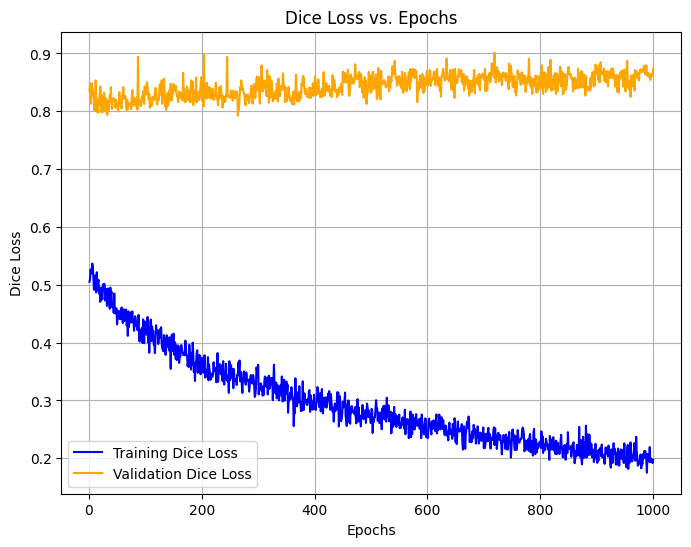

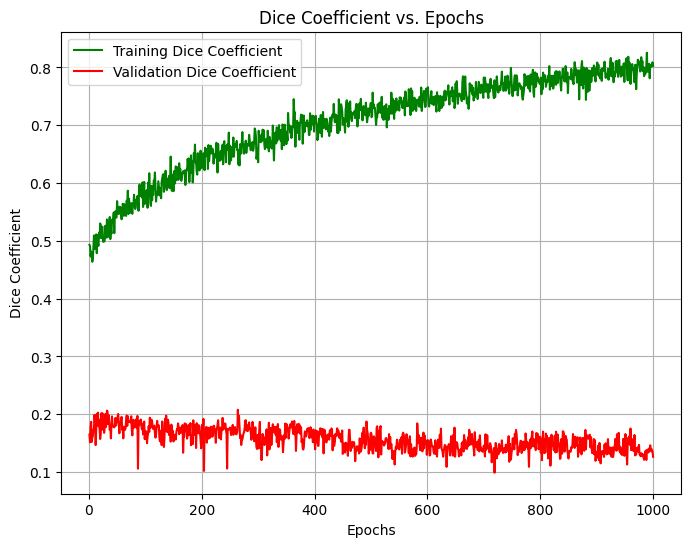


Plots saved to analysis


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


with open(f"{ANALYSIS}/metrics_{training_timestamp}.json", "r") as f:
    metrics = json.load(f)

epochs = range(1, len(metrics["loss"]) + 1)

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["loss"], label="Training Dice Loss", color="blue")
sns.lineplot(x=epochs, y=metrics["val_loss"], label="Validation Dice Loss", color="orange")
plt.title("Dice Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/dice_loss_plot_{training_timestamp}.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=epochs, y=metrics["dice_coefficient"], label="Training Dice Coefficient", color="green")
sns.lineplot(x=epochs, y=metrics["val_dice_coefficient"], label="Validation Dice Coefficient", color="red")
plt.title("Dice Coefficient vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid(True)
plt.savefig(f"{ANALYSIS}/dice_coefficient_plot_{training_timestamp}.png")
plt.show()

print(f"\nPlots saved to {ANALYSIS}")

## Step 10: Test the Model

In [34]:
start_time = time.time()
results = model.predict(features_test, verbose=1)
prediction_duration = time.time() - start_time
image_prediction_time = prediction_duration / len(features_test)

predictions = (results.squeeze(-1) > 0.5).astype("int32")
predictions_flat = predictions.flatten()
labels_test_flat = labels_test.flatten()

print(f"Total prediction time: {prediction_duration:.4f} seconds")
print(f"Time per image: {image_prediction_time:.4f} seconds")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step
Total prediction time: 1.8803 seconds
Time per image: 0.0232 seconds


## Step 11: Display the Results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def visualize_comparison(filename, true_mask, predicted_mask):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(true_mask, cmap="gray")
    plt.title(f"True Mask: {filename}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask: {filename}")
    plt.axis("off")

    plt.show()

for filename, true_mask, predicted_mask in zip(basenames_test, labels_test, predictions):
    visualize_comparison(filename, true_mask, predicted_mask)

## Step 12: Pixel-wise Segmentation Evaluation

> Evaluate the spatial map accuracy of predicted shear line binary mask using segmentation metrics.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def iou(y_true, y_pred):
    intersection = np.logical_and(y_true.astype(bool), y_pred.astype(bool)).sum()
    union = np.logical_or(y_true.astype(bool), y_pred.astype(bool)).sum()
    return intersection / union if union > 0 else 0.0

def dice(y_true, y_pred):
    intersection = np.logical_and(y_true.astype(bool), y_pred.astype(bool)).sum()
    denominator = y_true.astype(bool).sum() + y_pred.astype(bool).sum()
    return 2 * intersection / denominator if denominator > 0 else 0.0

ious = []
dices = []
accuracies = []

for t_mask, p_mask in zip(labels_test, predictions):
    t_mask = t_mask.reshape(161, 141)
    p_mask = p_mask.reshape(161, 141)

    ious.append(iou(t_mask, p_mask))
    dices.append(dice(t_mask, p_mask))
    accuracies.append(np.mean(t_mask.flatten() == p_mask.flatten()))

iou_score = np.mean(ious)
dice_score = np.mean(dices)
pixel_accuracy = np.mean(accuracies)

true_all = np.concatenate([t.flatten() for t in labels_test])
pred_all = np.concatenate([p.flatten() for p in predictions])

cm = confusion_matrix(true_all, pred_all, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Shear Line", "Shear Line"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="magma", ax=ax)
plt.title(f"IoU={iou_score:.4f}, Dice={dice_score:.4f}")
plt.savefig(f"{ANALYSIS}/confusion_matrix_{training_timestamp}.png")
plt.show()

iou_interpretation = {
    (0.90, 1.00): "Excellent",
    (0.75, 0.90): "Good",
    (0.50, 0.75): "Moderate",
    (0.20, 0.50): "Poor",
    (0.00, 0.20): "Very Poor"
}

dice_interpretation = {
    (0.90, 1.00): "Excellent",
    (0.75, 0.90): "Good",
    (0.50, 0.75): "Moderate",
    (0.20, 0.50): "Poor",
    (0.00, 0.20): "Very Poor"
}

for score_range, interpretation in iou_interpretation.items():
    if score_range[0] <= iou_score <= score_range[1]:
        print(f"IoU Interpretation: {interpretation}")
        break

for score_range, interpretation in dice_interpretation.items():
    if score_range[0] <= dice_score <= score_range[1]:
        print(f"Dice Interpretation: {interpretation}")
        break

# Notes: 2025-05-15
# The issue with the initial codes, is that the IoU and Dice scores
# were computed on the last prediction only. This was fixed
# by looping on all predictions and computing each scores
# before getting the average of all results.

# Step 13: Duplicate Notebook  

**Note:** Manually save first before duplicating the notebook.

In [ ]:
VALIDATIONS = "validations"
os.makedirs(VALIDATIONS, exist_ok=True)

filename = "ShearLineCNN.ipynb"
with open(filename, "r", encoding="utf-8") as src:
    contents = src.read()
    checkpoint = f"{VALIDATIONS}/{filename}".replace(".ipynb", f"_{training_timestamp}.ipynb")
    with open(checkpoint, "w", encoding="utf-8") as dest:
        dest.write(contents)
        print(f"Checkpoint was created at '{checkpoint}'.")

Checkpoint was created at 'validations/ShearLineCNN_1747315107.ipynb'.


> End of code.